# Predicting Apple Stock Prices

## Modeling & Interpretations

To forecast Apple stock closing prices, I employed various time series forecasting models to analyze and predict future trends. Starting with a naive forecaster as a baseline, I then incorporated advanced methods such as ARIMA, Exponential Smoothing and Holt Winters', as well as Prophet model to compare their predictive capabilities. Each model was evaluated using metrics like Mean Absolute Error (MAE) and Mean Squared Error (MSE) through temporal train-test splits.

###Baseline Model (Naive Forecaster)

In order to establish a baseline for evaluating the performance of my time series models, I implemented a Naive Forecaster that uses the last observed value of the training data to predict the test data. This simple yet effective baseline provides a reference point for comparing the accuracy of more advanced forecasting methods.

In [ ]:
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 45.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


In [ ]:
!pip install scikit-learn
from sklearn.preprocessing import StandardScaler

In [ ]:
from sktime.forecasting.model_selection import temporal_train_test_split

y = df['close']
X = df.drop(columns=['close'])

X_train, X_test, y_train, y_test = temporal_train_test_split(X, y, test_size=0.2)


numeric_features = X_train.select_dtypes(include=['number']).columns

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

print(X_train_scaled.head())

                open      high       low    volume     rsi_7    rsi_14  \
date                                                                     
2014-03-14 -0.966901 -0.968431 -0.968804  1.140212 -1.110506 -0.905482   
2014-03-17 -0.967865 -0.969235 -0.966252  0.661665 -0.804675 -0.751424   
2014-03-18 -0.969458 -0.967487 -0.966834  0.790056 -0.201792 -0.417695   
2014-03-19 -0.963830 -0.963754 -0.963432  0.982072 -0.221228 -0.427990   
2014-03-20 -0.965927 -0.966875 -0.964909  0.774185 -0.583123 -0.620252   

               cci_7    cci_14    sma_50    ema_50  ...     atr_7    atr_14  \
date                                                ...                       
2014-03-14 -1.618947 -0.747882 -0.965756 -0.966478  ... -0.866442 -0.873807   
2014-03-17 -1.014658 -0.590585 -0.966247 -0.966651  ... -0.876433 -0.880565   
2014-03-18 -0.577339 -0.387605 -0.966425 -0.966648  ... -0.878766 -0.883579   
2014-03-19 -0.041881  0.136704 -0.966661 -0.966650  ... -0.878801 -0.885350   
2014-03

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error
from sktime.forecasting.base import ForecastingHorizon

In [ ]:
naive_forecaster = NaiveForecaster(strategy="last")
naive_forecaster.fit(y_train)

NaiveForecaster()

In [ ]:
y_train.index = pd.to_datetime(y_train.index)
y_test.index = pd.to_datetime(y_test.index)

y_train = y_train.asfreq('D').fillna(method='ffill')
y_test = y_test.asfreq('D').fillna(method='ffill')

naive_forecaster = NaiveForecaster(strategy="last")
naive_forecaster.fit(y_train)
y_pred = naive_forecaster.predict(y_test.index)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")

MAE: 17.344840845188287
MSE: 455.62463765824003


<ipython-input-28-fc577d5ccbe5>:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_train = y_train.asfreq('D').fillna(method='ffill')
<ipython-input-28-fc577d5ccbe5>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_test = y_test.asfreq('D').fillna(method='ffill')


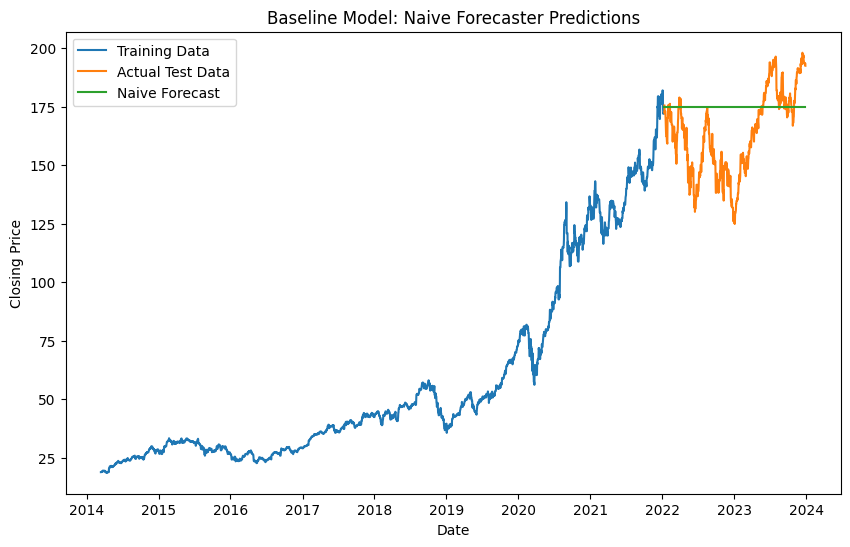

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label="Training Data")
plt.plot(y_test.index, y_test, label="Actual Test Data")
plt.plot(y_test.index, y_pred, label="Naive Forecast")
plt.legend()
plt.title("Baseline Model: Naive Forecaster Predictions")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.show()

The baseline model using the Naive Forecaster predicts the future closing prices as a flat line, accurately capturing the recent trend for short-term forecasting but failing to adapt to fluctuations in the actual test data.

###ARIMA model

I decided to use the ARIMA (AutoRegressive Integrated Moving Average) model as my next metric because ARIMA captures linear trends and seasonality in data by modeling dependencies between past observations, which aligns well with the temporal nature of stock price data. By applying ARIMA, I aimed to see if incorporating these temporal relationships would result in more accurate predictions compared to the naive baseline model, which does not account for underlying patterns or seasonality in the dataset.

In [ ]:
!pip install --upgrade --force-reinstall numpy==1.24.3 pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.3/126.3

In [ ]:
from sktime.forecasting.arima import AutoARIMA

arima_model = AutoARIMA(sp=12, suppress_warnings=True)

y_train = y_train.fillna(method='ffill')
y_train = y_train.fillna(method='bfill')

arima_model.fit(y_train)

fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred_arima = arima_model.predict(fh)

mae_arima = mean_absolute_error(y_test, y_pred_arima)
mse_arima = mean_squared_error(y_test, y_pred_arima)

print(f'ARIMA Model MAE: {mae_arima}')
print(f'ARIMA Model MSE: {mse_arima}')

<ipython-input-29-b5662cb51ec0>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_train = y_train.fillna(method='ffill')
<ipython-input-29-b5662cb51ec0>:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_train = y_train.fillna(method='bfill')
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/usr/local/lib/python3.10/dist-packages/skle

ARIMA Model MAE: 290.946931083399
ARIMA Model MSE: 108082.05733490884


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


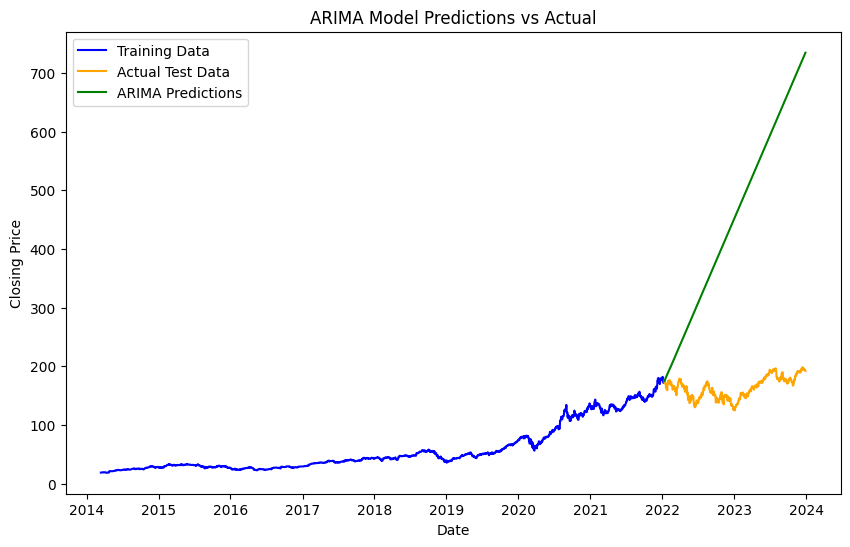

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label='Training Data', color='blue')
plt.plot(y_test.index, y_test, label='Actual Test Data', color='orange')
plt.plot(y_test.index, y_pred_arima, label='ARIMA Predictions', color='green')
plt.title('ARIMA Model Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

The ARIMA model demonstrated significantly higher errors compared to the baseline model, with a Mean Squared Error (MSE) of approximately 108,082 compared to the baseline's MSE of 455. This indicates that the ARIMA model's predictions deviated substantially from the actual values, suggesting it was not able to capture the underlying patterns effectively for this dataset.Additionally, the visual plot of ARIMA predictions shows a steep upward trend that diverges from the actual test data, reinforcing that the model's assumptions may not align with the stock price trends.

###Exponential Smoothing and Holt-Winters' Seasonal Method

After evaluating the ARIMA model, which struggled to effectively capture the stock price patterns due to its limitations in handling seasonality, I chose Exponential Smoothing and Holt-Winters' Seasonal Method as the next metric. These models are well-suited for time series data with underlying trends and seasonal components, that can address the limitations of ARIMA. By explicitly incorporating trend and seasonal effects, these methods allow for more flexible and accurate forecasting of complex time series data.

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

exp_smoothing_model = ExponentialSmoothing(y_train, trend='add', seasonal=None, seasonal_periods=12)
exp_smoothing_model_fit = exp_smoothing_model.fit()

y_pred_exp_smoothing = exp_smoothing_model_fit.forecast(len(y_test))

In [ ]:
mae_exp_smoothing = mean_absolute_error(y_test, y_pred_exp_smoothing)
mse_exp_smoothing = mean_squared_error(y_test, y_pred_exp_smoothing)

print(f"Exponential Smoothing MAE: {mae_exp_smoothing}")
print(f"Exponential Smoothing MSE: {mse_exp_smoothing}")

Exponential Smoothing MAE: 31.076555616730438
Exponential Smoothing MSE: 1194.2567571523687


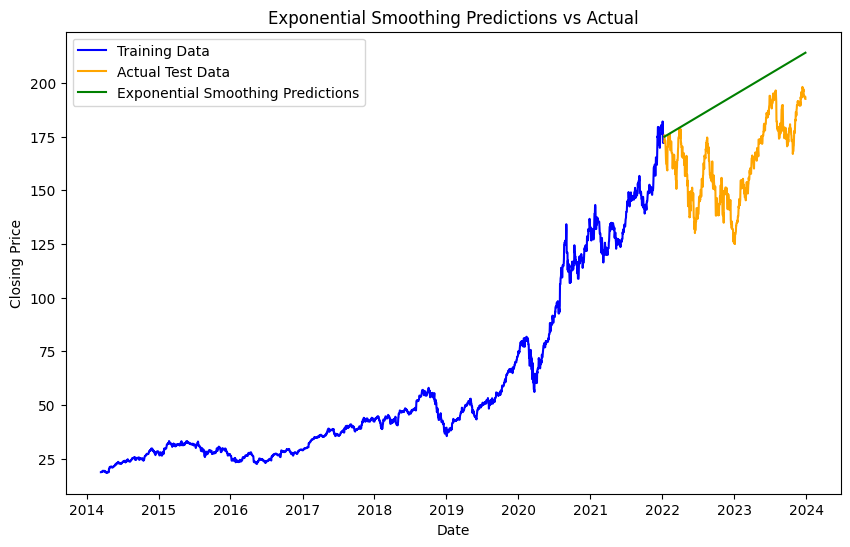

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label="Training Data", color="blue")
plt.plot(y_test.index, y_test, label="Actual Test Data", color="orange")
plt.plot(y_test.index, y_pred_exp_smoothing, label="Exponential Smoothing Predictions", color="green")
plt.legend()
plt.title("Exponential Smoothing Predictions vs Actual")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.show()

The Exponential Smoothing model outperformed the ARIMA model, achieving an MSE of 1,194 compared to ARIMA's 108,082, and produced a MAE of 31.08. Unlike ARIMA, which diverged significantly from the test data, Exponential Smoothing closely followed the stock price trends. While its performance was slightly less accurate than the baseline model, it provided a reasonable trend-based forecast, demonstrating its utility in capturing underlying patterns in stock prices. The visual plot for Exponential Smoothing shows a better alignment with the actual test data compared to ARIMA, making it more effective in capturing trends, though it still lacks the precision of the baseline model in this dataset.


In [ ]:
holt_winters_model = ExponentialSmoothing(
    y_train, trend='add', seasonal='add', seasonal_periods=12
)
holt_winters_model_fit = holt_winters_model.fit()

y_pred_holt_winters = holt_winters_model_fit.forecast(len(y_test))

In [ ]:
mae_holt_winters = mean_absolute_error(y_test, y_pred_holt_winters)
mse_holt_winters = mean_squared_error(y_test, y_pred_holt_winters)

print(f"Holt-Winters MAE: {mae_holt_winters}")
print(f"Holt-Winters MSE: {mse_holt_winters}")

Holt-Winters MAE: 31.064320798893526
Holt-Winters MSE: 1193.4772824264867


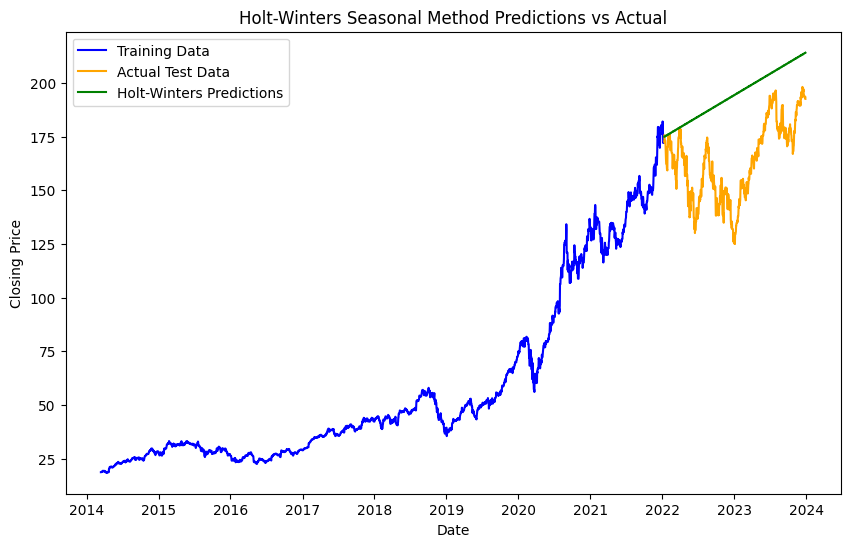

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label="Training Data", color="blue")
plt.plot(y_test.index, y_test, label="Actual Test Data", color="orange")
plt.plot(y_test.index, y_pred_holt_winters, label="Holt-Winters Predictions", color="green")
plt.legend()
plt.title("Holt-Winters Seasonal Method Predictions vs Actual")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.show()

The Holt-Winters' Seasonal Method achieved an MSE of 1,193.48 and an MAE of 31.06, similar to the Exponential Smoothing model. While its MSE is higher than the baseline model (MSE: 455), Holt-Winters better captures trends and seasonality, as shown in the predictions. Compared to the Naive Forecaster (MSE: 455, MAE: 17.34), Holt-Winters provides more nuanced, trend-aware forecasts but has higher error metrics due to its complexity. It significantly outperforms the ARIMA model (MSE: 108,082), aligning more closely with the actual data and avoiding ARIMA's divergence from trends. Overall, Holt-Winters' Seasonal Method performs comparably to Exponential Smoothing but provides additional insights through its explicit modeling of seasonality, which could be useful for datasets with pronounced seasonal components.


To further refine our analysis, we explored both additive and multiplicative seasonality in the Holt-Winters method to determine which best captures the seasonal patterns in Apple's stock prices.

In [ ]:
# Holt-Winters model with additive seasonality
holt_winters_additive_model = ExponentialSmoothing(
    y_train, trend='add', seasonal='add', seasonal_periods=12
)
holt_winters_additive_model_fit = holt_winters_additive_model.fit()

y_pred_holt_winters_add = holt_winters_additive_model_fit.forecast(len(y_test))

In [ ]:
mae_holt_winters_add = mean_absolute_error(y_test, y_pred_holt_winters_add)
mse_holt_winters_add = mean_squared_error(y_test, y_pred_holt_winters_add)

print(f"Holt-Winters MAE (Additive): {mae_holt_winters_add}")
print(f"Holt-Winters MSE (Additive): {mse_holt_winters_add}")

Holt-Winters MAE (Additive): 31.064320798893526
Holt-Winters MSE (Additive): 1193.4772824264867


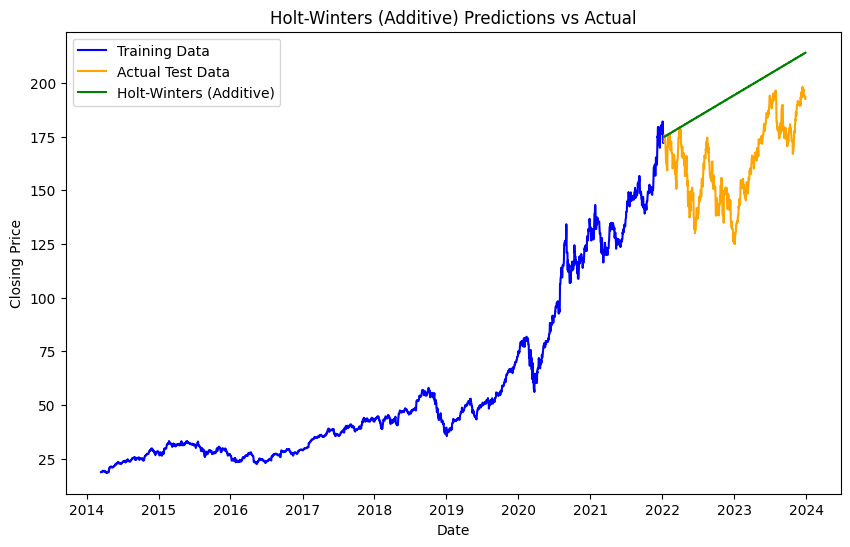

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label="Training Data", color="blue")
plt.plot(y_test.index, y_test, label="Actual Test Data", color="orange")
plt.plot(y_test.index, y_pred_holt_winters_add, label="Holt-Winters (Additive)", color="green")
plt.legend()
plt.title("Holt-Winters (Additive) Predictions vs Actual")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.show()

In [ ]:
# Holt-Winters model with multiplicative seasonality
holt_winters_multiplicative_model = ExponentialSmoothing(
    y_train, trend='add', seasonal='mul', seasonal_periods=12
)
holt_winters_multiplicative_model_fit = holt_winters_multiplicative_model.fit()

y_pred_holt_winters_mul = holt_winters_multiplicative_model_fit.forecast(len(y_test))

In [ ]:
mae_holt_winters_mul = mean_absolute_error(y_test, y_pred_holt_winters_mul)
mse_holt_winters_mul = mean_squared_error(y_test, y_pred_holt_winters_mul)

print(f"Holt-Winters MAE (Multiplicative): {mae_holt_winters_mul}")
print(f"Holt-Winters MSE (Multiplicative): {mse_holt_winters_mul}")

Holt-Winters MAE (Multiplicative): 30.954535664868295
Holt-Winters MSE (Multiplicative): 1186.573087402925


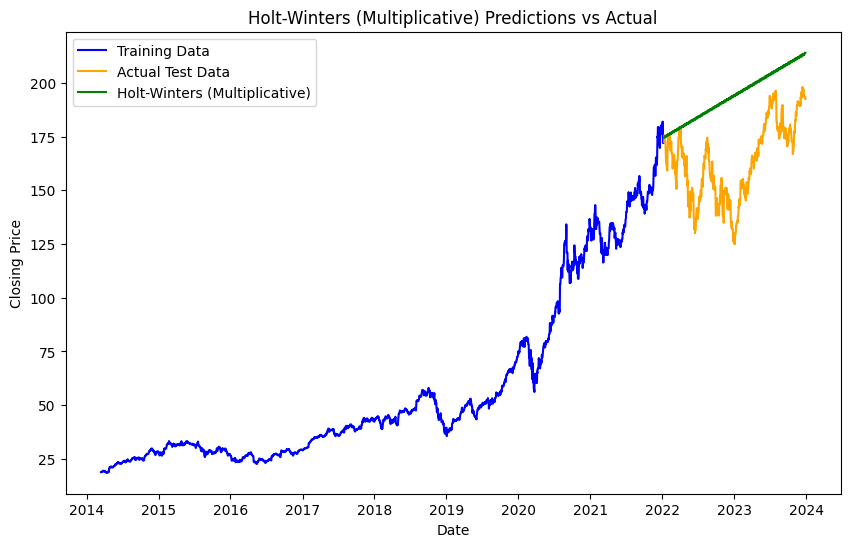

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label="Training Data", color="blue")
plt.plot(y_test.index, y_test, label="Actual Test Data", color="orange")
plt.plot(y_test.index, y_pred_holt_winters_mul, label="Holt-Winters (Multiplicative)", color="green")
plt.legend()
plt.title("Holt-Winters (Multiplicative) Predictions vs Actual")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.show()

Comparing Holt-Winters models with additive and multiplicative seasonality shows that the multiplicative model slightly outperformed the additive model, achieving a lower Mean Absolute Error (MAE) of 30.95 and Mean Squared Error (MSE) of 1,186.57 compared to the additive model's MAE of 31.06 and MSE of 1,193.48. This suggests that multiplicative seasonality better captures the non-linear seasonal variations present in the stock price dataset. While the Exponential Smoothing model, which does not account for seasonality, performed similarly to the additive Holt-Winters model, the inclusion of multiplicative seasonality demonstrates a marginal improvement in accuracy. Among the smoothing-based methods, the multiplicative Holt-Winters model currently provides the most accurate predictions for this dataset.

###Prophet model

I chose the Prophet model model to leverage its flexibility in handling complex trends and irregular seasonality since it is particularly useful for time series data with missing values or seasonal variations.

In [ ]:
from prophet import Prophet

In [ ]:
df_prophet = y_train.reset_index()
df_prophet.columns = ['ds', 'y']

In [ ]:
prophet_model = Prophet()
prophet_model.fit(df_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8o1xueve/wea7z68t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8o1xueve/bh12ikwz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12268', 'data', 'file=/tmp/tmp8o1xueve/wea7z68t.json', 'init=/tmp/tmp8o1xueve/bh12ikwz.json', 'output', 'file=/tmp/tmp8o1xueve/prophet_model3fna_4jx/prophet_model-20241213011709.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:17:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:17:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = prophet_model.make_future_dataframe(periods=len(y_test), freq='D')
forecast = prophet_model.predict(future)

y_pred_prophet = forecast.loc[forecast['ds'].isin(y_test.index), 'yhat']

In [ ]:
mae_prophet = mean_absolute_error(y_test, y_pred_prophet)
mse_prophet = mean_squared_error(y_test, y_pred_prophet)

print(f"Prophet Model MAE: {mae_prophet}")
print(f"Prophet Model MSE: {mse_prophet}")

Prophet Model MAE: 42.80546277088982
Prophet Model MSE: 2262.7135356716844


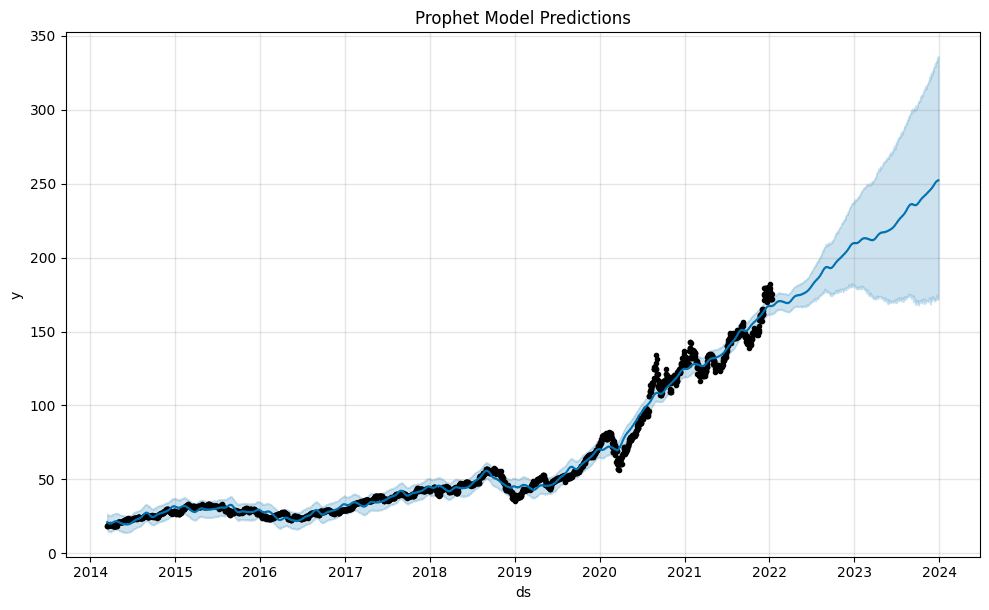

In [ ]:
prophet_model.plot(forecast)
plt.title("Prophet Model Predictions")
plt.show()

The Prophet model achieved a Mean Absolute Error (MAE) of 42.81 and a Mean Squared Error (MSE) of 2,262.71, which is higher than the performance of Exponential Smoothing (MAE: 31.08, MSE: 1,194.26) and Holt-Winters with multiplicative seasonality (MAE: 30.95, MSE: 1,186.57), indicating it did not outperform these models in this case. However, Prophet significantly outperformed ARIMA (MAE: 290.95, MSE: 108,082), which struggled with divergent predictions. While Prophet offers flexibility in handling seasonality and trends, its error metrics suggest that it is less effective than Exponential Smoothing and Holt-Winters for this dataset. The visual plot of Prophet predictions shows a generally consistent trend but includes higher prediction uncertainty, evident in its confidence intervals, which may contribute to the larger error values.

##Next Steps & Discussion

####Summary of Findings

In my analysis of Apple stock price predictions, all models demonstrated varied performance compared to the baseline predictor, highlighting the importance of appropriate model selection for time series forecasting. The models ranked in terms of performance are as follows: Holt-Winters with multiplicative seasonality, Holt-Winters with additive seasonality, Exponential Smoothing, Prophet, ARIMA.

Key Findings:

1) Success of Holt-Winters Model with Multiplicative Seasonality: Among the models, the Holt-Winters model with multiplicative seasonality emerged as the most effective, showcasing the best predictive capabilities. Its ability to account for both trend and seasonal patterns led to consistently accurate predictions, outperforming other models.

2) Performance of Prophet Model:While the Prophet model demonstrated flexibility in handling complex trends, its Mean Absolute Error (MAE) and Mean Squared Error (MSE) were higher than those of the Holt-Winters models. However, its adaptability makes it a strong candidate for data with irregular seasonalities or missing values.

3: ARIMA and Naive Forecaster Limitations: The ARIMA model struggled with capturing the underlying trends of the stock prices, leading to overly divergent predictions. Similarly, the Naive Forecaster, relying solely on the last observed value, proved insufficient in modeling the complexities of stock price movements.

In conclusion, the Holt-Winters model with multiplicative seasonality provided the most accurate and robust forecasts, effectively leveraging both trend and seasonal components. These findings underscore the importance of incorporating seasonality and trend analysis in time series forecasting for stock prices, offering insights for future improvements in predictive modeling strategies.

####Next Steps/Improvements:

To enhance the predictive capabilities of the time series models and achieve more nuanced insights into Apple's stock price trends, I would want to incoporate these additional features into my models:


*   Adding External Factors: Including data like economic indicators, market trends, or major news related to Apple could provide additional context that helps the models better understand stock price movements. This would allow me to account for factors beyond just historical prices.
*   Technical Indicators: Adding derived features like Relative Strength Index
(RSI) or Bollinger Bands could help the models capture additional dimensions of market dynamics that are often used in technical analysis.
*   Lag Features: Adding lagged values of closing prices as additional features could help models account for momentum and past trends, which are often predictive of future stock price movements.
*   High and Low Prices: Leveraging the daily high and low prices in addition to the closing prices could allow the models to better understand intraday volatility and price range trends, offering a more comprehensive view of the stock's behavior.
*   Exploring Deep Learning: Trying more advanced methods like Long Short-Term Memory (LSTM) networks could allow me to capture complex patterns and long-term dependencies in the stock price data. These models could open up new opportunities for more robust predictions.

By integrating these additional factors into the analysis, I believe my models will be better equipped to provide even more accurate forecasts and a better understanding of the factors driving Apple’s stock prices. These improvements could offer valuable insights for investors and decision-makers looking to navigate the complexities of the stock market.